In [95]:
import pandas as pd
import matplotlib.pyplot as plt

In [96]:
from gbd_mapping import causes
from vivarium_inputs import get_measure

In [97]:
dfout = pd.read_hdf(r'../2019_12_16_15_24_27/output.hdf')

In [98]:
print(dfout.head())
print(dfout.shape)

                               total_population_untracked  \
input_draw_number random_seed                               
774.0             12.0                                0.0   
620.0             7.0                                 0.0   
428.0             7.0                                 0.0   
629.0             7.0                                 0.0   
35.0              29.0                                0.0   

                               total_population_tracked  total_population  \
input_draw_number random_seed                                               
774.0             12.0                          11125.0           11125.0   
620.0             7.0                           11202.0           11202.0   
428.0             7.0                           11077.0           11077.0   
629.0             7.0                           11103.0           11103.0   
35.0              29.0                          11124.0           11124.0   

                               d

In [99]:
dfout.columns

Index(['total_population_untracked', 'total_population_tracked',
       'total_population', 'diarrheal_diseases_prevalent_cases_at_sim_end',
       'susceptible_to_diarrheal_diseases_event_count',
       'diarrheal_diseases_event_count',
       'lower_respiratory_infections_prevalent_cases_at_sim_end',
       'susceptible_to_lower_respiratory_infections_event_count',
       'lower_respiratory_infections_event_count',
       'measles_prevalent_cases_at_sim_end',
       ...
       'ylds_due_to_hemolytic_disease_and_other_neonatal_jaundice_among_male_in_age_group_early_neonatal',
       'ylds_due_to_hemolytic_disease_and_other_neonatal_jaundice_among_female_in_age_group_early_neonatal',
       'ylds_due_to_hemolytic_disease_and_other_neonatal_jaundice_among_male_in_age_group_late_neonatal',
       'ylds_due_to_hemolytic_disease_and_other_neonatal_jaundice_among_female_in_age_group_late_neonatal',
       'ylds_due_to_hemolytic_disease_and_other_neonatal_jaundice_among_male_in_age_group_pos

In [100]:
#print(dfout.index)
dfout.reset_index(level='random_seed',inplace=True,drop=True)
dfout.head()

,total_population_untracked,total_population_tracked,total_population,diarrheal_diseases_prevalent_cases_at_sim_end,susceptible_to_diarrheal_diseases_event_count,diarrheal_diseases_event_count,lower_respiratory_infections_prevalent_cases_at_sim_end,susceptible_to_lower_respiratory_infections_event_count,lower_respiratory_infections_event_count,measles_prevalent_cases_at_sim_end,...,ylds_due_to_hemolytic_disease_and_other_neonatal_jaundice_among_male_in_age_group_early_neonatal,ylds_due_to_hemolytic_disease_and_other_neonatal_jaundice_among_female_in_age_group_early_neonatal,ylds_due_to_hemolytic_disease_and_other_neonatal_jaundice_among_male_in_age_group_late_neonatal,ylds_due_to_hemolytic_disease_and_other_neonatal_jaundice_among_female_in_age_group_late_neonatal,ylds_due_to_hemolytic_disease_and_other_neonatal_jaundice_among_male_in_age_group_post_neonatal,ylds_due_to_hemolytic_disease_and_other_neonatal_jaundice_among_female_in_age_group_post_neonatal,ylds_due_to_hemolytic_disease_and_other_neonatal_jaundice_among_male_in_age_group_1_to_4,ylds_due_to_hemolytic_disease_and_other_neonatal_jaundice_among_female_in_age_group_1_to_4,ylds_due_to_hemolytic_disease_and_other_neonatal_jaundice_among_male_in_age_group_5_to_9,ylds_due_to_hemolytic_disease_and_other_neonatal_jaundice_among_female_in_age_group_5_to_9
input_draw_number,,,,,,,,,,,,,,,,,,,,,
774.0,0.0,11125.0,11125.0,158.0,54629.0,54598.0,30.0,6714.0,6733.0,1967.0,...,0.026022,0.018107,0.068335,0.056917,0.839457,0.918801,2.655930,2.874451,1.659308,0.696769
620.0,0.0,11202.0,11202.0,119.0,50760.0,50698.0,31.0,7806.0,7824.0,3604.0,...,0.011439,0.007265,0.034326,0.000000,0.299267,0.051982,1.241030,1.027536,0.973146,0.628681
428.0,0.0,11077.0,11077.0,128.0,53738.0,53683.0,44.0,9280.0,9298.0,1859.0,...,0.009628,0.014266,0.028868,0.032618,0.357428,0.418773,1.892716,2.548931,1.691858,1.079468
629.0,0.0,11103.0,11103.0,147.0,48209.0,48201.0,23.0,7245.0,7264.0,5050.0,...,0.021292,0.017423,0.089755,0.047727,0.968620,0.599637,2.658724,1.806129,0.168659,0.047049
35.0,0.0,11124.0,11124.0,129.0,50738.0,50690.0,30.0,7301.0,7324.0,1961.0,...,0.019814,0.015914,0.053369,0.059134,0.696715,0.816398,1.356036,2.255698,0.592952,0.013884


In [101]:
dfout.reset_index(level='input_draw_number',inplace=True)
dfout.head()

,input_draw_number,total_population_untracked,total_population_tracked,total_population,diarrheal_diseases_prevalent_cases_at_sim_end,susceptible_to_diarrheal_diseases_event_count,diarrheal_diseases_event_count,lower_respiratory_infections_prevalent_cases_at_sim_end,susceptible_to_lower_respiratory_infections_event_count,lower_respiratory_infections_event_count,...,ylds_due_to_hemolytic_disease_and_other_neonatal_jaundice_among_male_in_age_group_early_neonatal,ylds_due_to_hemolytic_disease_and_other_neonatal_jaundice_among_female_in_age_group_early_neonatal,ylds_due_to_hemolytic_disease_and_other_neonatal_jaundice_among_male_in_age_group_late_neonatal,ylds_due_to_hemolytic_disease_and_other_neonatal_jaundice_among_female_in_age_group_late_neonatal,ylds_due_to_hemolytic_disease_and_other_neonatal_jaundice_among_male_in_age_group_post_neonatal,ylds_due_to_hemolytic_disease_and_other_neonatal_jaundice_among_female_in_age_group_post_neonatal,ylds_due_to_hemolytic_disease_and_other_neonatal_jaundice_among_male_in_age_group_1_to_4,ylds_due_to_hemolytic_disease_and_other_neonatal_jaundice_among_female_in_age_group_1_to_4,ylds_due_to_hemolytic_disease_and_other_neonatal_jaundice_among_male_in_age_group_5_to_9,ylds_due_to_hemolytic_disease_and_other_neonatal_jaundice_among_female_in_age_group_5_to_9
0,774.0,0.0,11125.0,11125.0,158.0,54629.0,54598.0,30.0,6714.0,6733.0,...,0.026022,0.018107,0.068335,0.056917,0.839457,0.918801,2.655930,2.874451,1.659308,0.696769
1,620.0,0.0,11202.0,11202.0,119.0,50760.0,50698.0,31.0,7806.0,7824.0,...,0.011439,0.007265,0.034326,0.000000,0.299267,0.051982,1.241030,1.027536,0.973146,0.628681
2,428.0,0.0,11077.0,11077.0,128.0,53738.0,53683.0,44.0,9280.0,9298.0,...,0.009628,0.014266,0.028868,0.032618,0.357428,0.418773,1.892716,2.548931,1.691858,1.079468
3,629.0,0.0,11103.0,11103.0,147.0,48209.0,48201.0,23.0,7245.0,7264.0,...,0.021292,0.017423,0.089755,0.047727,0.968620,0.599637,2.658724,1.806129,0.168659,0.047049
4,35.0,0.0,11124.0,11124.0,129.0,50738.0,50690.0,30.0,7301.0,7324.0,...,0.019814,0.015914,0.053369,0.059134,0.696715,0.816398,1.356036,2.255698,0.592952,0.013884


In [102]:
df_grpby_draws = dfout.groupby('input_draw_number',as_index=False).sum()
print(df_grpby_draws.head())
print(df_grpby_draws.shape)

   input_draw_number  total_population_untracked  total_population_tracked  \
0                3.0                         0.0                  111263.0   
1                8.0                         0.0                  111019.0   
2               21.0                         0.0                  110958.0   
3               29.0                         0.0                  111042.0   
4               35.0                         0.0                  111086.0   

   total_population  diarrheal_diseases_prevalent_cases_at_sim_end  \
0          111263.0                                         1316.0   
1          111019.0                                         1193.0   
2          110958.0                                         1188.0   
3          111042.0                                         1421.0   
4          111086.0                                         1251.0   

   susceptible_to_diarrheal_diseases_event_count  \
0                                       516155.0   
1     

In [103]:
deaths_measles = df_grpby_draws.filter(regex='input_draw_number|death_due_to_measles')
deaths_measles.set_index('input_draw_number', inplace=True)
deaths_measles.head()

,death_due_to_measles_among_male_in_age_group_early_neonatal,death_due_to_measles_among_female_in_age_group_early_neonatal,death_due_to_measles_among_male_in_age_group_late_neonatal,death_due_to_measles_among_female_in_age_group_late_neonatal,death_due_to_measles_among_male_in_age_group_post_neonatal,death_due_to_measles_among_female_in_age_group_post_neonatal,death_due_to_measles_among_male_in_age_group_1_to_4,death_due_to_measles_among_female_in_age_group_1_to_4,death_due_to_measles_among_male_in_age_group_5_to_9,death_due_to_measles_among_female_in_age_group_5_to_9,...,death_due_to_measles_among_male_in_age_group_75_to_79,death_due_to_measles_among_female_in_age_group_75_to_79,death_due_to_measles_among_male_in_age_group_80_to_84,death_due_to_measles_among_female_in_age_group_80_to_84,death_due_to_measles_among_male_in_age_group_85_to_89,death_due_to_measles_among_female_in_age_group_85_to_89,death_due_to_measles_among_male_in_age_group_90_to_94,death_due_to_measles_among_female_in_age_group_90_to_94,death_due_to_measles_among_male_in_age_group_95_plus,death_due_to_measles_among_female_in_age_group_95_plus
input_draw_number,,,,,,,,,,,,,,,,,,,,,
3.0,0.0,0.0,0.0,0.0,2.0,0.0,6.0,12.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.0,0.0,0.0,0.0,0.0,5.0,6.0,33.0,28.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21.0,0.0,0.0,0.0,0.0,3.0,4.0,18.0,16.0,7.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29.0,0.0,0.0,0.0,0.0,0.0,2.0,22.0,16.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35.0,0.0,0.0,0.0,0.0,1.0,1.0,22.0,11.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
person_time = df_grpby_draws.filter(regex='input_draw_number|person_time')
person_time.set_index('input_draw_number',inplace=True)
person_time.head()

,person_time_among_male_in_age_group_early_neonatal,person_time_among_female_in_age_group_early_neonatal,person_time_among_male_in_age_group_late_neonatal,person_time_among_female_in_age_group_late_neonatal,person_time_among_male_in_age_group_post_neonatal,person_time_among_female_in_age_group_post_neonatal,person_time_among_male_in_age_group_1_to_4,person_time_among_female_in_age_group_1_to_4,person_time_among_male_in_age_group_5_to_9,person_time_among_female_in_age_group_5_to_9,...,person_time_among_male_in_age_group_75_to_79,person_time_among_female_in_age_group_75_to_79,person_time_among_male_in_age_group_80_to_84,person_time_among_female_in_age_group_80_to_84,person_time_among_male_in_age_group_85_to_89,person_time_among_female_in_age_group_85_to_89,person_time_among_male_in_age_group_90_to_94,person_time_among_female_in_age_group_90_to_94,person_time_among_male_in_age_group_95_plus,person_time_among_female_in_age_group_95_plus
input_draw_number,,,,,,,,,,,,,,,,,,,,,
3.0,113.719506,104.183306,356.932582,327.213191,9958.155753,9149.021708,135026.966292,122357.158058,129607.264398,117452.983522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.0,110.857053,102.494755,350.271581,323.768342,9904.328611,9079.981976,134560.180951,121940.958274,130466.996401,117549.232992,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21.0,111.402810,101.706146,354.408672,318.322309,9854.822157,9033.046079,134232.064783,122647.051715,129140.076386,117765.553030,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29.0,109.385014,104.765030,345.378581,327.953553,9771.894556,9202.463760,133703.800309,122144.771896,130292.209759,117875.563356,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35.0,113.086362,102.201919,356.854531,322.469819,9979.823149,9156.795691,134454.902189,122510.565934,129896.334265,117150.638115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
csmr_measles_columns = [i.replace('death_due_to','csmr') for i in deaths_measles.columns]
csmr_measles_columns

['csmr_measles_among_male_in_age_group_early_neonatal',
 'csmr_measles_among_female_in_age_group_early_neonatal',
 'csmr_measles_among_male_in_age_group_late_neonatal',
 'csmr_measles_among_female_in_age_group_late_neonatal',
 'csmr_measles_among_male_in_age_group_post_neonatal',
 'csmr_measles_among_female_in_age_group_post_neonatal',
 'csmr_measles_among_male_in_age_group_1_to_4',
 'csmr_measles_among_female_in_age_group_1_to_4',
 'csmr_measles_among_male_in_age_group_5_to_9',
 'csmr_measles_among_female_in_age_group_5_to_9',
 'csmr_measles_among_male_in_age_group_10_to_14',
 'csmr_measles_among_female_in_age_group_10_to_14',
 'csmr_measles_among_male_in_age_group_15_to_19',
 'csmr_measles_among_female_in_age_group_15_to_19',
 'csmr_measles_among_male_in_age_group_20_to_24',
 'csmr_measles_among_female_in_age_group_20_to_24',
 'csmr_measles_among_male_in_age_group_25_to_29',
 'csmr_measles_among_female_in_age_group_25_to_29',
 'csmr_measles_among_male_in_age_group_30_to_34',
 'csmr_m

In [106]:
person_time.columns = deaths_measles.columns
person_time.head()

,death_due_to_measles_among_male_in_age_group_early_neonatal,death_due_to_measles_among_female_in_age_group_early_neonatal,death_due_to_measles_among_male_in_age_group_late_neonatal,death_due_to_measles_among_female_in_age_group_late_neonatal,death_due_to_measles_among_male_in_age_group_post_neonatal,death_due_to_measles_among_female_in_age_group_post_neonatal,death_due_to_measles_among_male_in_age_group_1_to_4,death_due_to_measles_among_female_in_age_group_1_to_4,death_due_to_measles_among_male_in_age_group_5_to_9,death_due_to_measles_among_female_in_age_group_5_to_9,...,death_due_to_measles_among_male_in_age_group_75_to_79,death_due_to_measles_among_female_in_age_group_75_to_79,death_due_to_measles_among_male_in_age_group_80_to_84,death_due_to_measles_among_female_in_age_group_80_to_84,death_due_to_measles_among_male_in_age_group_85_to_89,death_due_to_measles_among_female_in_age_group_85_to_89,death_due_to_measles_among_male_in_age_group_90_to_94,death_due_to_measles_among_female_in_age_group_90_to_94,death_due_to_measles_among_male_in_age_group_95_plus,death_due_to_measles_among_female_in_age_group_95_plus
input_draw_number,,,,,,,,,,,,,,,,,,,,,
3.0,113.719506,104.183306,356.932582,327.213191,9958.155753,9149.021708,135026.966292,122357.158058,129607.264398,117452.983522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.0,110.857053,102.494755,350.271581,323.768342,9904.328611,9079.981976,134560.180951,121940.958274,130466.996401,117549.232992,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21.0,111.402810,101.706146,354.408672,318.322309,9854.822157,9033.046079,134232.064783,122647.051715,129140.076386,117765.553030,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29.0,109.385014,104.765030,345.378581,327.953553,9771.894556,9202.463760,133703.800309,122144.771896,130292.209759,117875.563356,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35.0,113.086362,102.201919,356.854531,322.469819,9979.823149,9156.795691,134454.902189,122510.565934,129896.334265,117150.638115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
csmr_measles = deaths_measles.div(person_time)
csmr_measles.columns = csmr_measles_columns
csmr_measles = csmr_measles.fillna(0)

In [108]:
csmr_measles

,csmr_measles_among_male_in_age_group_early_neonatal,csmr_measles_among_female_in_age_group_early_neonatal,csmr_measles_among_male_in_age_group_late_neonatal,csmr_measles_among_female_in_age_group_late_neonatal,csmr_measles_among_male_in_age_group_post_neonatal,csmr_measles_among_female_in_age_group_post_neonatal,csmr_measles_among_male_in_age_group_1_to_4,csmr_measles_among_female_in_age_group_1_to_4,csmr_measles_among_male_in_age_group_5_to_9,csmr_measles_among_female_in_age_group_5_to_9,...,csmr_measles_among_male_in_age_group_75_to_79,csmr_measles_among_female_in_age_group_75_to_79,csmr_measles_among_male_in_age_group_80_to_84,csmr_measles_among_female_in_age_group_80_to_84,csmr_measles_among_male_in_age_group_85_to_89,csmr_measles_among_female_in_age_group_85_to_89,csmr_measles_among_male_in_age_group_90_to_94,csmr_measles_among_female_in_age_group_90_to_94,csmr_measles_among_male_in_age_group_95_plus,csmr_measles_among_female_in_age_group_95_plus
input_draw_number,,,,,,,,,,,,,,,,,,,,,
3.0,0.0,0.0,0.0,0.0,0.000201,0.000000,0.000044,0.000098,0.000008,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.0,0.0,0.0,0.0,0.0,0.000505,0.000661,0.000245,0.000230,0.000000,0.000017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21.0,0.0,0.0,0.0,0.0,0.000304,0.000443,0.000134,0.000130,0.000054,0.000017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29.0,0.0,0.0,0.0,0.0,0.000000,0.000217,0.000165,0.000131,0.000015,0.000008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35.0,0.0,0.0,0.0,0.0,0.000100,0.000109,0.000164,0.000090,0.000000,0.000009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50.0,0.0,0.0,0.0,0.0,0.000100,0.000110,0.000178,0.000139,0.000031,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55.0,0.0,0.0,0.0,0.0,0.000296,0.000439,0.000229,0.000214,0.000023,0.000034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78.0,0.0,0.0,0.0,0.0,0.000402,0.000218,0.000052,0.000106,0.000000,0.000026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100.0,0.0,0.0,0.0,0.0,0.000100,0.000547,0.000185,0.000156,0.000000,0.000026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
csmr_mean = csmr_measles.mean()
csmr_mean= pd.DataFrame(csmr_mean, columns = ['csmr'])
csmr_mean.reset_index(inplace=True)
csmr_mean

,index,csmr
0,csmr_measles_among_male_in_age_group_early_neo...,0.000000
1,csmr_measles_among_female_in_age_group_early_n...,0.000000
2,csmr_measles_among_male_in_age_group_late_neon...,0.000000
3,csmr_measles_among_female_in_age_group_late_ne...,0.000000
4,csmr_measles_among_male_in_age_group_post_neon...,0.000435
5,csmr_measles_among_female_in_age_group_post_ne...,0.000439
6,csmr_measles_among_male_in_age_group_1_to_4,0.000172
7,csmr_measles_among_female_in_age_group_1_to_4,0.000186
8,csmr_measles_among_male_in_age_group_5_to_9,0.000016
9,csmr_measles_among_female_in_age_group_5_to_9,0.000021


In [110]:
def extract_sex(x):
    sex = x.split('_')[3]
    return sex    

In [111]:
csmr_mean['sex'] = csmr_mean['index'].apply(extract_sex)
csmr_mean

,index,csmr,sex
0,csmr_measles_among_male_in_age_group_early_neo...,0.000000,male
1,csmr_measles_among_female_in_age_group_early_n...,0.000000,female
2,csmr_measles_among_male_in_age_group_late_neon...,0.000000,male
3,csmr_measles_among_female_in_age_group_late_ne...,0.000000,female
4,csmr_measles_among_male_in_age_group_post_neon...,0.000435,male
5,csmr_measles_among_female_in_age_group_post_ne...,0.000439,female
6,csmr_measles_among_male_in_age_group_1_to_4,0.000172,male
7,csmr_measles_among_female_in_age_group_1_to_4,0.000186,female
8,csmr_measles_among_male_in_age_group_5_to_9,0.000016,male
9,csmr_measles_among_female_in_age_group_5_to_9,0.000021,female


In [112]:
def extract_age(x):
    age = x.split('age_group_')
    age = ' '.join(age[1].split('_'))
    if age == 'early neonatal':
        age = '0 to 7dys'
    elif age == 'late neonatal':
        age = '7 to 28dys'
    elif age == 'post neonatal':
        age = '28dys to 1yr'
    #print(age)
    return age

In [113]:
csmr_mean['age_group'] = csmr_mean['index'].apply(extract_age)
csmr_mean

,index,csmr,sex,age_group
0,csmr_measles_among_male_in_age_group_early_neo...,0.000000,male,0 to 7dys
1,csmr_measles_among_female_in_age_group_early_n...,0.000000,female,0 to 7dys
2,csmr_measles_among_male_in_age_group_late_neon...,0.000000,male,7 to 28dys
3,csmr_measles_among_female_in_age_group_late_ne...,0.000000,female,7 to 28dys
4,csmr_measles_among_male_in_age_group_post_neon...,0.000435,male,28dys to 1yr
5,csmr_measles_among_female_in_age_group_post_ne...,0.000439,female,28dys to 1yr
6,csmr_measles_among_male_in_age_group_1_to_4,0.000172,male,1 to 4
7,csmr_measles_among_female_in_age_group_1_to_4,0.000186,female,1 to 4
8,csmr_measles_among_male_in_age_group_5_to_9,0.000016,male,5 to 9
9,csmr_measles_among_female_in_age_group_5_to_9,0.000021,female,5 to 9


In [114]:
csmr_mes_sim = csmr_mean.loc[:,'csmr':'age_group']
csmr_mes_sim['sex'] = csmr_mes_sim['sex'] + ' - Sim'
csmr_mes_sim

,csmr,sex,age_group
0,0.000000,male - Sim,0 to 7dys
1,0.000000,female - Sim,0 to 7dys
2,0.000000,male - Sim,7 to 28dys
3,0.000000,female - Sim,7 to 28dys
4,0.000435,male - Sim,28dys to 1yr
5,0.000439,female - Sim,28dys to 1yr
6,0.000172,male - Sim,1 to 4
7,0.000186,female - Sim,1 to 4
8,0.000016,male - Sim,5 to 9
9,0.000021,female - Sim,5 to 9


In [115]:
plt.rcParams["figure.figsize"] = (25,10)

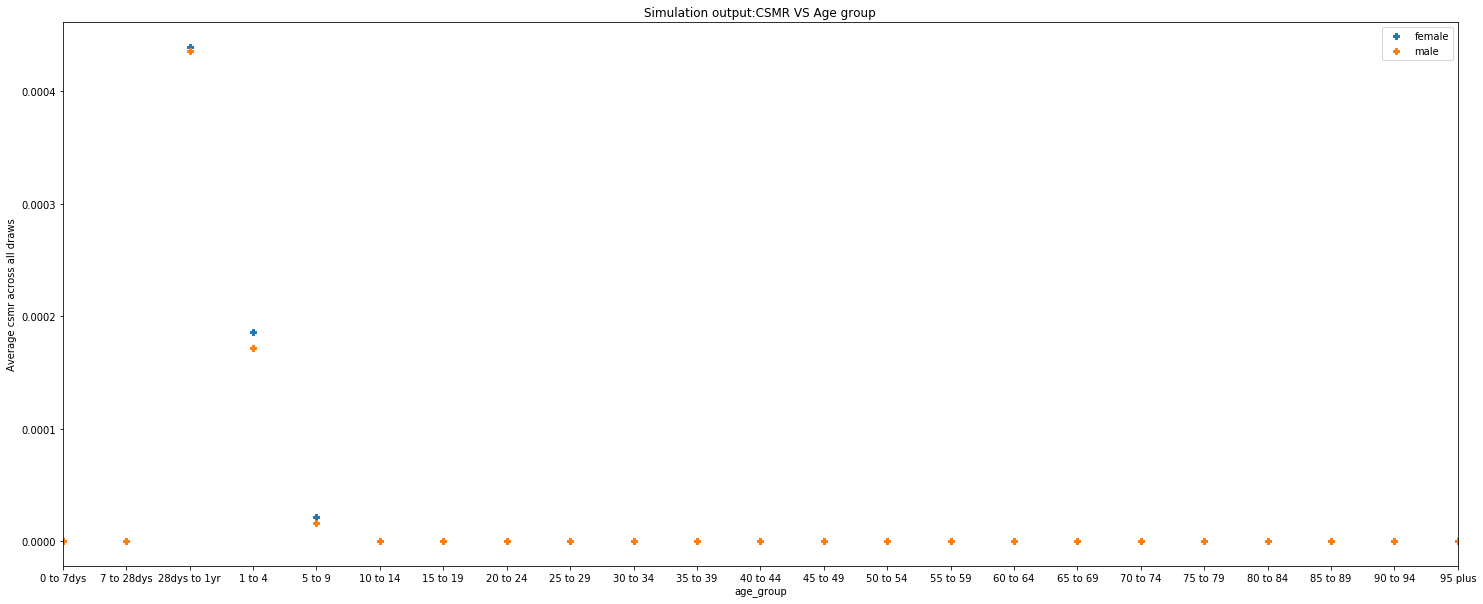

In [116]:
fig, ax = plt.subplots()
csmr_mean.groupby('sex').plot(x='age_group',y='csmr',marker = 'P',linestyle='',ax=ax)
plt.ylabel('Average csmr across all draws')
plt.title("Simulation output:CSMR VS Age group")
plt.xticks(range(23),csmr_mean['age_group'].unique())
plt.legend([v[0] for v in csmr_mean.groupby('sex')['sex']])

In [117]:
csmr_mes_ind_act = get_measure(causes.measles,'cause_specific_mortality_rate','India')

/share/code/kiranklc/miniconda/envs/vivarium/lib/python3.6/site-packages/vivarium_inputs/validation/raw.py:1405: UserWarning: Cause measles deaths data may violate the following restrictions: yll age restriction .
  warnings.warn(f'{entity.kind.capitalize()} {entity.name} {measure} data may violate the '
/share/code/kiranklc/miniconda/envs/vivarium/lib/python3.6/site-packages/vivarium_inputs/validation/raw.py:1858: UserWarning: Data contains additional age groups beyond those specified by restriction range.
  warnings.warn('Data contains additional age groups beyond those specified by restriction range.')
/share/code/kiranklc/miniconda/envs/vivarium/lib/python3.6/site-packages/vivarium_inputs/validation/raw.py:1960: UserWarning: Data was only expected to contain values for age groups between ids 4 and 15 but also included values for age groups {16}.
  warnings.warn(f'Data was only expected to contain values for age groups between ids '


In [118]:
csmr_mes_ind_act.head()

draw_0  draw_1  draw_2  \
location sex    age               year                                   
India    Female [0.0, 0.01917808) [1990, 1991)     0.0     0.0     0.0   
                                  [1991, 1992)     0.0     0.0     0.0   
                                  [1992, 1993)     0.0     0.0     0.0   
                                  [1993, 1994)     0.0     0.0     0.0   
                                  [1994, 1995)     0.0     0.0     0.0   

                                                draw_3  draw_4  draw_5  \
location sex    age               year                                   
India    Female [0.0, 0.01917808) [1990, 1991)     0.0     0.0     0.0   
                                  [1991, 1992)     0.0     0.0     0.0   
                                  [1992, 1993)     0.0     0.0     0.0   
                                  [1993, 1994)     0.0     0.0     0.0   
                                  [1994, 1995)     0.0     0.0     0.0   

                                                draw_6  draw_7  draw_8  \
location sex    age               year                                   
India    Female [0.0, 0.01917808) [1990, 1991)     0.0     0.0     0.0   
                                  [1991, 1992)     0.0     0.0     0.0   
                                  [1992, 1993)     0.0     0.0     0.0   
                                  [1993, 1994)     0.0     0.0     0.0   
                                  [1994, 1995)     0.0     0.0     0.0   

                                                draw_9  ...  draw_990  \
location sex    age               year                  ...             
India    Female [0.0, 0.01917808) [1990, 1991)     0.0  ...       0.0   
                                  [1991, 1992)     0.0  ...       0.0   
                                  [1992, 1993)     0.0  ...       0.0   
                                  [1993, 1994)     0.0  ...       0.0   
                                  [1994, 1995)     0.0  ...       0.0   

                                                draw_991  draw_992  draw_993  \
location sex    age               year                                         
India    Female [0.0, 0.01917808) [1990, 1991)       0.0       0.0       0.0   
                                  [1991, 1992)       0.0       0.0       0.0   
                                  [1992, 1993)       0.0       0.0       0.0   
                                  [1993, 1994)       0.0       0.0       0.0   
                                  [1994, 1995)       0.0       0.0       0.0   

                                                draw_994  draw_995  draw_996  \
location sex    age               year                                         
India    Female [0.0, 0.01917808) [1990, 1991)       0.0       0.0       0.0   
                                  [1991, 1992)       0.0       0.0       0.0   
                                  [1992, 1993)       0.0       0.0       0.0   
                                  [1993, 1994)       0.0       0.0       0.0   
                                  [1994, 1995)       0.0       0.0       0.0   

                                                draw_997  draw_998  draw_999  
location sex    age               year                                        
India    Female [0.0, 0.01917808) [1990, 1991)       0.0       0.0       0.0  
                                  [1991, 1992)       0.0       0.0       0.0  
                                  [1992, 1993)       0.0       0.0       0.0  
                                  [1993, 1994)       0.0       0.0       0.0  
                                  [1994, 1995)       0.0       0.0       0.0  

[5 rows x 1000 columns]

In [119]:
csmr_mes_ind_act.reset_index(inplace=True)
csmr_mes_ind_act.head()

,location,sex,age,year,draw_0,draw_1,draw_2,draw_3,draw_4,draw_5,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,India,Female,"[0.0, 0.01917808)","[1990, 1991)",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,India,Female,"[0.0, 0.01917808)","[1991, 1992)",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,India,Female,"[0.0, 0.01917808)","[1992, 1993)",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,India,Female,"[0.0, 0.01917808)","[1993, 1994)",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,India,Female,"[0.0, 0.01917808)","[1994, 1995)",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
csmr_mes_2011_2015 = csmr_mes_ind_act.loc[csmr_mes_ind_act['year'].apply(lambda x: x.left in [2010,2011,2012,2013,2014,2015]),:]
csmr_mes_2011_2015

,location,sex,age,year,draw_0,draw_1,draw_2,draw_3,draw_4,draw_5,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
20,India,Female,"[0.0, 0.01917808)","[2010, 2011)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
21,India,Female,"[0.0, 0.01917808)","[2011, 2012)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
22,India,Female,"[0.0, 0.01917808)","[2012, 2013)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
23,India,Female,"[0.0, 0.01917808)","[2013, 2014)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
24,India,Female,"[0.0, 0.01917808)","[2014, 2015)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25,India,Female,"[0.0, 0.01917808)","[2015, 2016)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
48,India,Female,"[0.01917808, 0.07671233)","[2010, 2011)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
49,India,Female,"[0.01917808, 0.07671233)","[2011, 2012)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50,India,Female,"[0.01917808, 0.07671233)","[2012, 2013)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
51,India,Female,"[0.01917808, 0.07671233)","[2013, 2014)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [121]:
csmr_mes_agg_years = csmr_mes_2011_2015.groupby(['sex','age'],as_index=False).mean()
csmr_mes_agg_years

,sex,age,draw_0,draw_1,draw_2,draw_3,draw_4,draw_5,draw_6,draw_7,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,Female,"[0.0, 0.01917808)",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,Female,"[0.01917808, 0.07671233)",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,Female,"[0.07671233, 1.0)",3.260630e-04,1.845625e-04,3.746194e-04,1.227681e-04,4.428843e-04,3.033913e-04,2.519456e-04,7.456828e-04,...,3.778595e-04,7.400996e-04,4.435105e-04,1.895266e-04,2.155577e-04,3.981226e-04,3.216953e-04,4.470977e-04,1.944469e-04,1.616001e-04
3,Female,"[1.0, 5.0)",1.722912e-04,9.160985e-05,1.881634e-04,6.995652e-05,2.334315e-04,1.581008e-04,1.380362e-04,4.127706e-04,...,2.209883e-04,4.107165e-04,2.385373e-04,1.083431e-04,1.178570e-04,2.194285e-04,1.856631e-04,2.268918e-04,1.207161e-04,1.133063e-04
4,Female,"[5.0, 10.0)",2.790188e-05,1.590497e-05,2.835304e-05,9.995164e-06,3.932622e-05,2.420380e-05,2.057801e-05,6.163224e-05,...,3.833929e-05,7.994903e-05,4.704528e-05,1.720290e-05,2.297896e-05,3.814679e-05,3.219376e-05,4.517771e-05,1.502839e-05,1.883121e-05
5,Female,"[10.0, 15.0)",8.178561e-06,4.345315e-06,8.281216e-06,2.932964e-06,1.070669e-05,6.842592e-06,5.942988e-06,1.772301e-05,...,1.059083e-05,2.158013e-05,1.162356e-05,4.491305e-06,5.962401e-06,9.994277e-06,8.466956e-06,1.145401e-05,4.166021e-06,5.051495e-06
6,Female,"[15.0, 20.0)",2.849084e-06,1.494394e-06,3.044843e-06,1.054437e-06,3.845662e-06,2.495735e-06,2.096807e-06,6.551680e-06,...,3.661536e-06,7.558366e-06,3.820466e-06,1.595890e-06,2.016247e-06,3.444864e-06,2.923440e-06,3.971012e-06,1.442181e-06,1.640628e-06
7,Female,"[20.0, 25.0)",1.682695e-06,8.598536e-07,1.810238e-06,6.045032e-07,2.259910e-06,1.407599e-06,1.241288e-06,3.760832e-06,...,1.988449e-06,4.054796e-06,2.162470e-06,8.991024e-07,1.159778e-06,1.945660e-06,1.664302e-06,2.225485e-06,8.224680e-07,9.085456e-07
8,Female,"[25.0, 30.0)",9.564909e-07,5.075252e-07,1.056328e-06,3.533106e-07,1.325636e-06,8.242772e-07,7.188100e-07,2.255528e-06,...,1.156480e-06,2.345914e-06,1.280030e-06,5.105644e-07,6.532320e-07,1.165095e-06,9.718644e-07,1.299379e-06,4.968368e-07,5.198708e-07
9,Female,"[30.0, 35.0)",7.215853e-07,3.749357e-07,7.854039e-07,2.660021e-07,9.863640e-07,6.138706e-07,5.463994e-07,1.699233e-06,...,8.975780e-07,1.786562e-06,9.796217e-07,3.924437e-07,5.054521e-07,8.672385e-07,7.331656e-07,9.857565e-07,3.832308e-07,3.983646e-07


In [122]:
csmr_mes_agg_years['mean_draws'] = csmr_mes_agg_years.loc[:,'draw_0':'draw_999'].mean(axis=1)
csmr_mes_agg_years[['sex','age','mean_draws']]

,sex,age,mean_draws
0,Female,"[0.0, 0.01917808)",0.000000e+00
1,Female,"[0.01917808, 0.07671233)",0.000000e+00
2,Female,"[0.07671233, 1.0)",3.760233e-04
3,Female,"[1.0, 5.0)",2.007824e-04
4,Female,"[5.0, 10.0)",3.355434e-05
5,Female,"[10.0, 15.0)",9.084904e-06
6,Female,"[15.0, 20.0)",3.247282e-06
7,Female,"[20.0, 25.0)",1.868490e-06
8,Female,"[25.0, 30.0)",1.089467e-06
9,Female,"[30.0, 35.0)",8.217516e-07


In [123]:
def convert_age_group(x):
    if x.right < 1:
        age_group = str(int(round(x.left*365)))+' to '+str(int(round((x.right)*365)))+'dys'
    elif x.right == 1:
        age_group = str(int(round(x.left*365)))+'dys to '+str(int(x.right))+'yr'
    elif x.right == 125:
        age_group = str(int(round(x.left)))+ ' plus'
    else:
        age_group = str(int(x.left))+' to '+str(int(x.right-1))
    #print(age_group)
    return age_group

In [124]:
csmr_mes_agg_years['age_group'] = csmr_mes_agg_years['age'].apply(convert_age_group)
csmr_mes_gbd = csmr_mes_agg_years.loc[:,['sex','mean_draws','age_group']]
csmr_mes_gbd['sex'] = csmr_mes_gbd['sex'].str.lower()

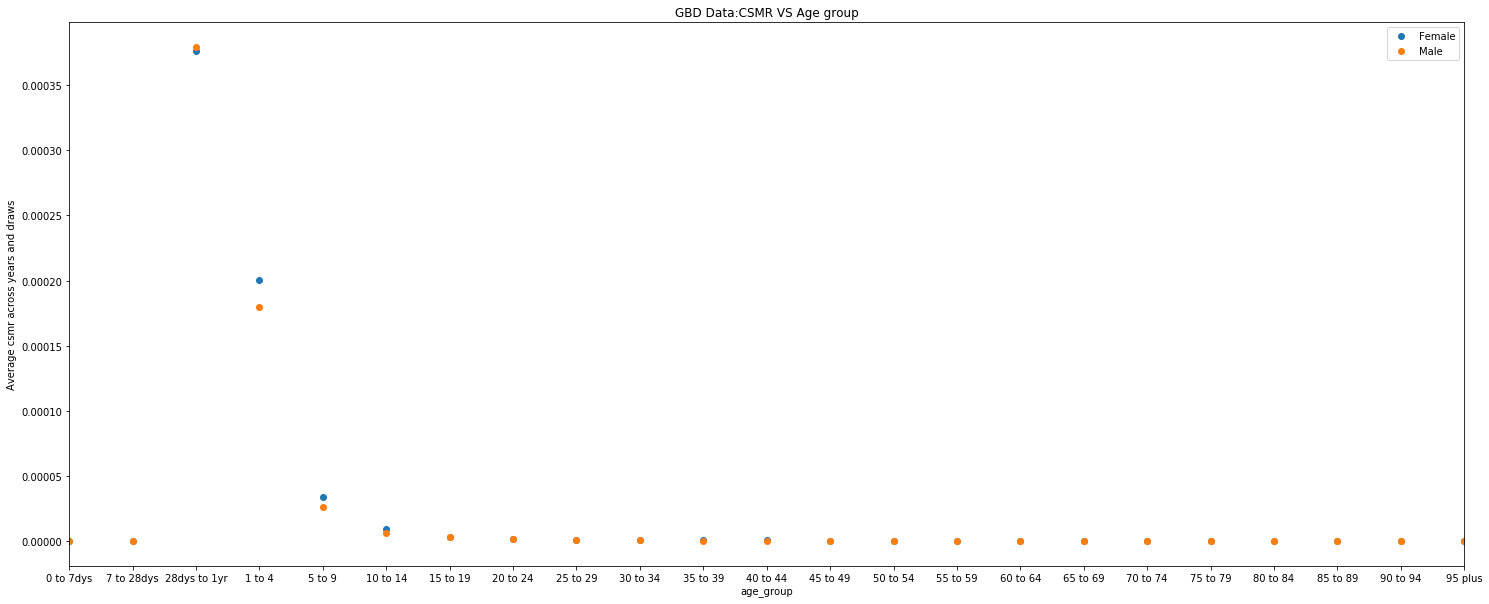

In [125]:
fig, ax = plt.subplots()
csmr_mes_agg_years.groupby('sex').plot(x='age_group',y='mean_draws',marker='o',linestyle='',ax=ax)
plt.ylabel('Average csmr across years and draws')
plt.title("GBD Data:CSMR VS Age group")
plt.xticks(range(23),csmr_mes_agg_years['age_group'].unique())
plt.legend([v[0] for v in csmr_mes_agg_years.groupby('sex')['sex']])

In [126]:
csmr_mes_gbd.rename(columns = {'mean_draws':'csmr'},inplace=True)
csmr_mes_gbd

,sex,csmr,age_group
0,female,0.000000e+00,0 to 7dys
1,female,0.000000e+00,7 to 28dys
2,female,3.760233e-04,28dys to 1yr
3,female,2.007824e-04,1 to 4
4,female,3.355434e-05,5 to 9
5,female,9.084904e-06,10 to 14
6,female,3.247282e-06,15 to 19
7,female,1.868490e-06,20 to 24
8,female,1.089467e-06,25 to 29
9,female,8.217516e-07,30 to 34


In [127]:
csmr_mes_gbd['sex'] = csmr_mes_gbd['sex'] +' - GBD'
csmr_mes_gbd

,sex,csmr,age_group
0,female - GBD,0.000000e+00,0 to 7dys
1,female - GBD,0.000000e+00,7 to 28dys
2,female - GBD,3.760233e-04,28dys to 1yr
3,female - GBD,2.007824e-04,1 to 4
4,female - GBD,3.355434e-05,5 to 9
5,female - GBD,9.084904e-06,10 to 14
6,female - GBD,3.247282e-06,15 to 19
7,female - GBD,1.868490e-06,20 to 24
8,female - GBD,1.089467e-06,25 to 29
9,female - GBD,8.217516e-07,30 to 34


In [128]:
csmr_mes_ind = pd.concat([csmr_mes_gbd,csmr_mes_sim], sort=False)
csmr_mes_ind

,sex,csmr,age_group
0,female - GBD,0.000000e+00,0 to 7dys
1,female - GBD,0.000000e+00,7 to 28dys
2,female - GBD,3.760233e-04,28dys to 1yr
3,female - GBD,2.007824e-04,1 to 4
4,female - GBD,3.355434e-05,5 to 9
5,female - GBD,9.084904e-06,10 to 14
6,female - GBD,3.247282e-06,15 to 19
7,female - GBD,1.868490e-06,20 to 24
8,female - GBD,1.089467e-06,25 to 29
9,female - GBD,8.217516e-07,30 to 34


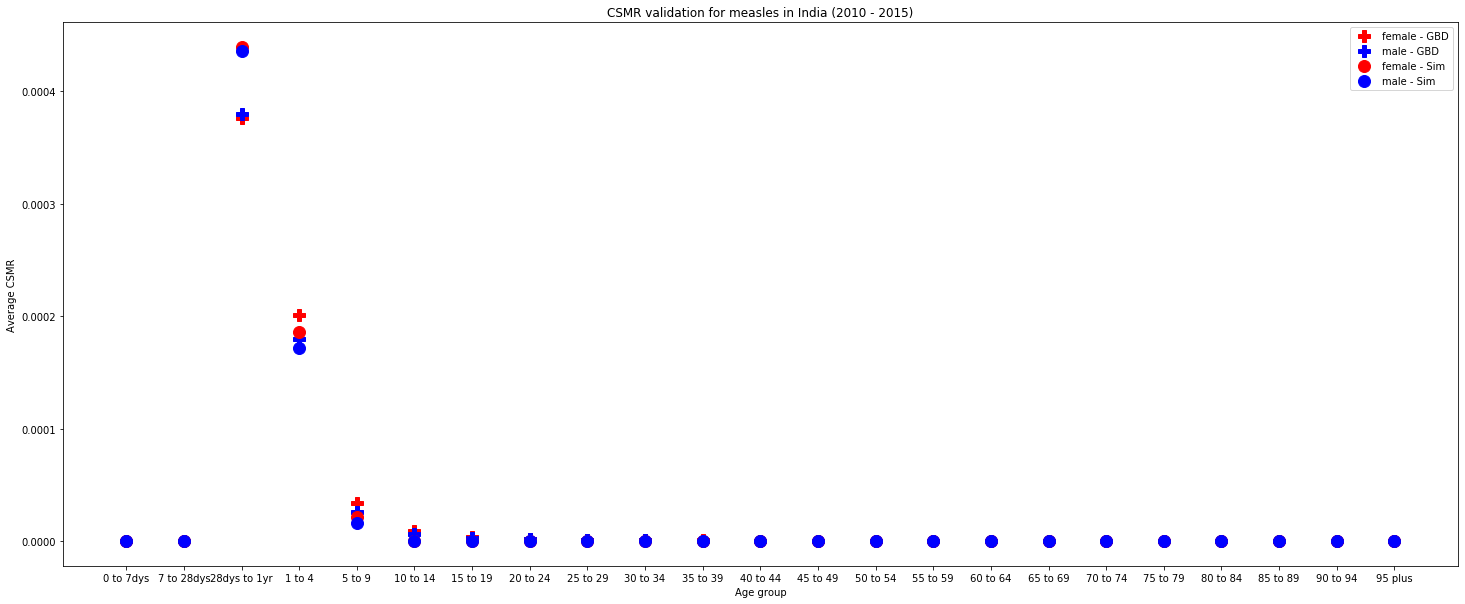

In [129]:
format_dict = {'female - GBD':"rP", 'male - GBD':"bP",'female - Sim':"ro",'male - Sim':"bo"}

fig, ax = plt.subplots()
for form in format_dict:
    df = csmr_mes_ind[csmr_mes_ind.sex == form]
    ax.plot(df.age_group,df.csmr, format_dict[form],linestyle='',ms=12,label=form)
ax.set_title('CSMR validation for measles in India (2010 - 2015)')    
ax.set_xlabel('Age group')
ax.set_ylabel('Average CSMR')
ax.legend()